## Set-up environment

In [1]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-0nq0okqg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-0nq0okqg
  Resolved https://github.com/huggingface/transformers.git to commit 3c2517727ce28a30f5044e01663ee204deb1cdbe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.0/521.0 kB 16.9 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=11106675 sha256=fc37261f93f7620af69dfb2af0a2b8764b136d8056b30b84c901d57c0a5f6132
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0r_9e2r/wheels/12/51/df/b62c8ce0479c5de6f7bef121169b3e946949a57481169d3155
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninsta

In [2]:
!pip install -q datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [3]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

data/train-00000-of-00001-fc7c825a216873(…):   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Let's retrieve the caption of the first example:

In [4]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

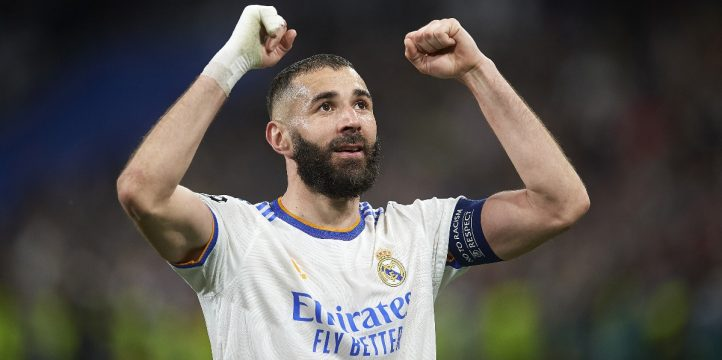

In [5]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [8]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Loading weights:   0%|          | 0/472 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [9]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [10]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.005792617797852
Loss: 10.25864028930664
Loss: 10.195215225219727
Epoch: 1
Loss: 10.17519474029541
Loss: 10.138788223266602
Loss: 10.177906036376953
Epoch: 2
Loss: 10.135533332824707
Loss: 10.113372802734375
Loss: 10.06718921661377
Epoch: 3
Loss: 10.085631370544434
Loss: 10.054548263549805
Loss: 10.035369873046875
Epoch: 4
Loss: 10.024303436279297
Loss: 9.988269805908203
Loss: 9.950833320617676
Epoch: 5
Loss: 9.453597068786621
Loss: 9.867716789245605
Loss: 9.366196632385254
Epoch: 6
Loss: 8.890853881835938
Loss: 8.642694473266602
Loss: 8.421098709106445
Epoch: 7
Loss: 8.173341751098633
Loss: 7.976726055145264
Loss: 7.790041446685791
Epoch: 8
Loss: 7.588114261627197
Loss: 7.357736110687256
Loss: 7.216203212738037
Epoch: 9
Loss: 7.031067848205566
Loss: 6.865211486816406
Loss: 6.740569591522217
Epoch: 10
Loss: 6.559474468231201
Loss: 6.4143500328063965
Loss: 6.288651466369629
Epoch: 11
Loss: 6.103369235992432
Loss: 5.988580226898193
Loss: 5.81652307510376
Epoch: 12
Loss: 5.6695036

## Inference

Let's check the results on our train dataset

In [1]:
# load image
example = dataset[0]
image = example["image"]
image

NameError: name 'dataset' is not defined

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid's win against psg
